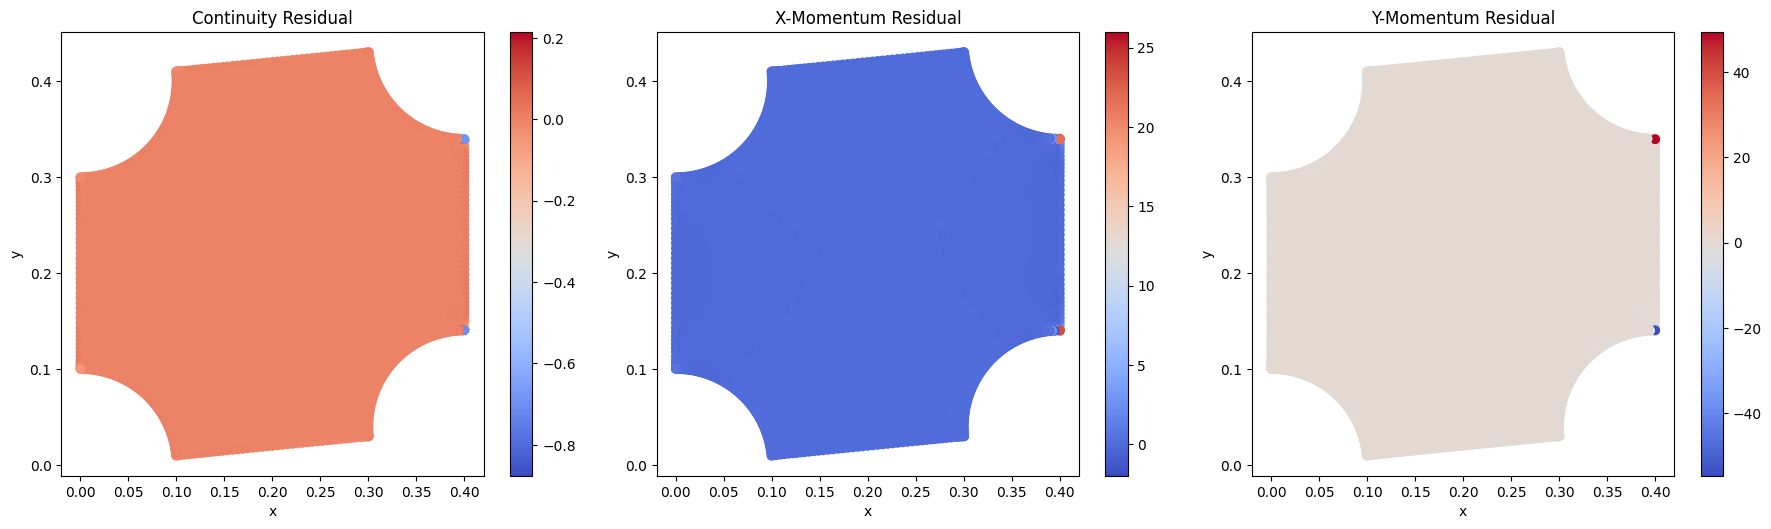

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RBFInterpolator

# Load the CSV file
df = pd.read_csv(f'data/unscaled/DRPINN_0.5_10_1.csv')  # Replace with your path

# Extract coordinates and fields
points = df[['x', 'y']].values
u = df['u'].values
v = df['v'].values
p = df['p'].values

# Interpolators
rbf_u = RBFInterpolator(points, u, kernel='thin_plate_spline')
rbf_v = RBFInterpolator(points, v, kernel='thin_plate_spline')
rbf_p = RBFInterpolator(points, p, kernel='thin_plate_spline')

# Gradient and Laplacian functions
def numerical_gradient(f_interp, pts, h=1e-4):
    grads = []
    for i in range(2):
        offset = np.zeros_like(pts)
        offset[:, i] = h
        grad_i = (f_interp(pts + offset) - f_interp(pts - offset)) / (2 * h)
        grads.append(grad_i)
    return grads

def numerical_laplacian(f_interp, pts, h=1e-4):
    lap = np.zeros(len(pts))
    for i in range(2):
        offset = np.zeros_like(pts)
        f_plus = f_interp(pts + offset)
        f_minus = f_interp(pts - offset)
        f_center = f_interp(pts)
        lap += (f_plus - 2 * f_center + f_minus) / h**2
    return lap

# Derivatives
du_dx, du_dy = numerical_gradient(rbf_u, points)
dv_dx, dv_dy = numerical_gradient(rbf_v, points)
dp_dx, dp_dy = numerical_gradient(rbf_p, points)
lap_u = numerical_laplacian(rbf_u, points)
lap_v = numerical_laplacian(rbf_v, points)

# Residuals
mu = 0.01
cont_res = du_dx + dv_dy
mom_x_res = u * du_dx + v * du_dy + dp_dx - mu * lap_u
mom_y_res = u * dv_dx + v * dv_dy + dp_dy - mu * lap_v

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

sc1 = axs[0].scatter(points[:, 0], points[:, 1], c=cont_res, cmap='coolwarm')
axs[0].set_title('Continuity Residual')
plt.colorbar(sc1, ax=axs[0])

sc2 = axs[1].scatter(points[:, 0], points[:, 1], c=mom_x_res, cmap='coolwarm')
axs[1].set_title('X-Momentum Residual')
plt.colorbar(sc2, ax=axs[1])

sc3 = axs[2].scatter(points[:, 0], points[:, 1], c=mom_y_res, cmap='coolwarm')
axs[2].set_title('Y-Momentum Residual')
plt.colorbar(sc3, ax=axs[2])

for ax in axs:
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_aspect('equal')

plt.tight_layout()
plt.show()


In [7]:
# Mean absolute residuals
avg_continuity = np.mean(np.abs(cont_res))
avg_momentum_x = np.mean(np.abs(mom_x_res))
avg_momentum_y = np.mean(np.abs(mom_y_res))

print("Average Continuity Residual: ", avg_continuity)
print("Average X-Momentum Residual: ", avg_momentum_x)
print("Average Y-Momentum Residual: ", avg_momentum_y)


Average Continuity Residual:  0.0015434590758881957
Average X-Momentum Residual:  0.09376056463174885
Average Y-Momentum Residual:  0.09837313014617705
